In [1]:
import math
import importlib
from typing import Literal

import torch
from torch import Tensor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ax import Client, RangeParameterConfig

from botorch.models import SingleTaskGP
from botorch.acquisition import qLogExpectedImprovement, qMaxValueEntropy

from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior

from src.ax_helper import get_full_strategy
from src import GPVisualiser, ax_helper
from src.ax_helper import get_guess_coords
import logging
from src.ax_helper import silence_ax_client
from src.ax_helper import get_full_strategy

import pickle

silence_ax_client()


-0.0 -0.9874311636230129


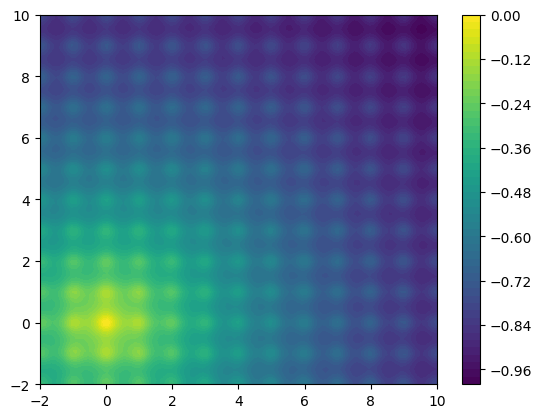

In [2]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    ),
    RangeParameterConfig(
        name="x2", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1", "x2"]


def test_function(x1, x2):
    # Ackley function (commonly used for optimization benchmarks)
    a = 20
    b = 0.2
    c = 2 * math.pi
    sum_sq = 0.5 * (x1**2 + x2**2)
    cos_comp = 0.5 * (math.cos(c * x1) + math.cos(c * x2))
    ackley_grid = -a * math.exp(-b * math.sqrt(sum_sq)) - math.exp(cos_comp) + a + math.exp(1)
    standardized = (ackley_grid-0.2434339681166695)/(19.3680592868830)
    return -standardized


import numpy as np
grid = np.linspace(-2, 10, 101)
x1_grid, x2_grid = np.meshgrid(grid, grid)
ackley_vals = np.array([test_function(x1, x2) for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel())]).reshape(x1_grid.shape)
ackley_vals
print(ackley_vals.max(), ackley_vals.min())


plt.contourf(x1_grid, x2_grid, ackley_vals, levels=60, cmap="viridis")
plt.colorbar()

# Sobol
The default initial parameter exploration strategy uses SOBOL algorithm:

### log param sobol:

In [3]:
import logging
import builtins

class SuppressInfoPrefix(logging.Filter):
    def filter(self, record):
        return not record.getMessage().startswith('[INFO')

# Create and register the filter globally (all loggers)
_filter = SuppressInfoPrefix()
root_logger = logging.getLogger()
root_logger.addFilter(_filter)
for handler in root_logger.handlers:
    handler.addFilter(_filter)

# Also add to any already-created loggers
for logger_name, lg in logging.root.manager.loggerDict.items():
    if isinstance(lg, logging.Logger):
        lg.addFilter(_filter)
        for h in lg.handlers:
            h.addFilter(_filter)

# Optional: suppress bare print() lines starting with '[INFO'
_original_print = builtins.print
def filtered_print(*args, **kwargs):
    if args and isinstance(args[0], str) and args[0].startswith('[INFO'):
        return
    _original_print(*args, **kwargs)

builtins.print = filtered_print


   trial_name         x0         x1
0         0_0  10.000000  10.000000
1         1_0   1.576090  14.394855
2         2_0  82.250417   6.663923
3         3_0  17.915069  78.743514
4         4_0   3.924221   1.323900
5         5_0   6.280545  37.895665
6         6_0  12.036370   2.695820
7         7_0  55.262235  22.455573
8         8_0   2.522385   4.359149
9         9_0   2.145541  66.620440
10       10_0  35.243422   1.439889
11       11_0  14.150941  13.242710
12       12_0   9.847647   7.872136
13       13_0   4.614284  26.965789
14       14_0  28.086178   3.788504
15       15_0  69.952373  43.579237
16       16_0   1.005291   2.246190
17       17_0   1.250631  56.033159
18       18_0  56.265039   1.873042
19       19_0  26.087393  27.995169
20       20_0   4.970957   3.403434
21       21_0   7.914846  10.275015
22       22_0  17.595424   9.420074
23       23_0  37.948477  64.307514
24       24_0   1.991338   1.606554
25       25_0   3.122343  18.735685
26       26_0  44.615287   5

<Axes: xlabel='x0', ylabel='x1'>

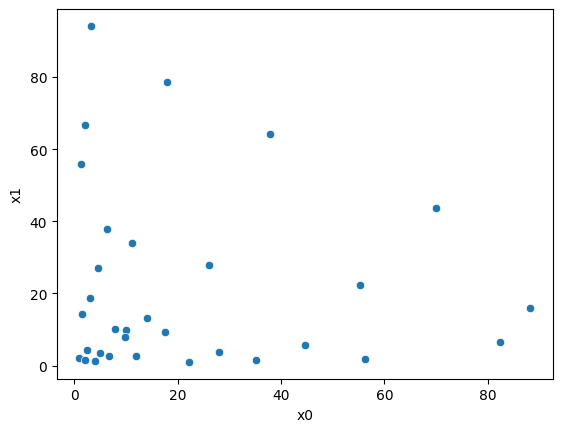

In [4]:

client = Client()
client.verbose_logging = False
#client.verbose_logging = False

client.configure_experiment(
    name="batch_bo_test",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(1, 100),
            parameter_type="float",
            scaling = 'log',
        ) for i in range(len(dim_names))
    ],
)

client.configure_optimization(objective="-loss")
client.get_next_trials(max_trials=32)
coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x0", y="x1")

Low value oversampling is inline with logarithmic distribution.

**Considering that we expect overexpression to be optimal when compared to underexpression, Sobol should be run on a linear scale**.

### linear parameters sobol

<Axes: xlabel='x1', ylabel='x2'>

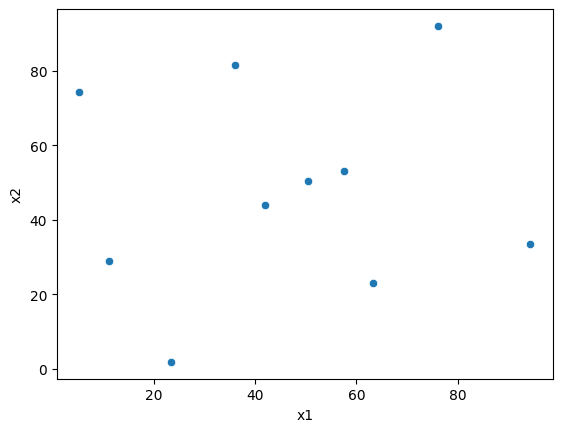

In [5]:
client = Client()

parameters=[
    RangeParameterConfig(
        name=dim,
        bounds=(1, 100),
        parameter_type="float",
        # scaling = 'log',
    ) for dim in dim_names
]


client.configure_experiment(
    name="batch_bo_test",
    parameters=parameters
)

client.configure_optimization(objective="response")
client.get_next_trials(max_trials=10)

coords = get_guess_coords(client)

sns.scatterplot(data=coords, x="x1", y="x2")

A nice and informative initial guess grid is formed

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\botorch\models\utils\assorted.py:270: InputDataWarning:

Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.



(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'GP along x1'}, xlabel='x1', ylabel='response'>,
        <Axes: title={'center': 'GP along x2'}, xlabel='x2', ylabel='response'>],
       dtype=object))

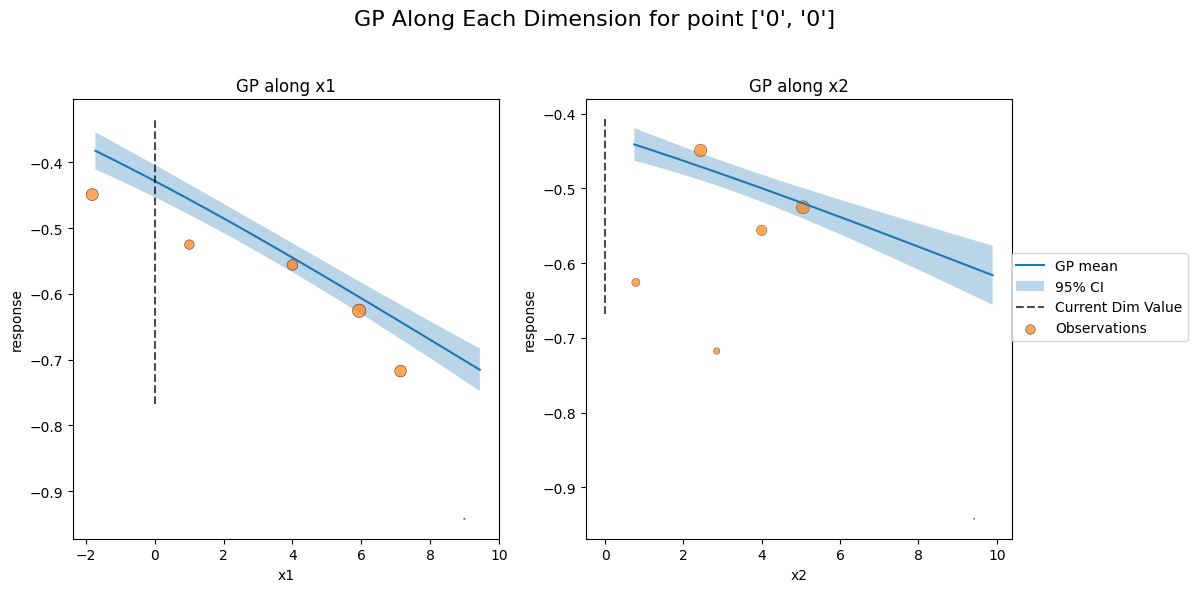

In [6]:
client = Client()

client.configure_experiment(parameters=range_parameters)


client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=6, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

df = ax_helper.get_obs_from_client(client, response_col='response')
plotter = GPVisualiser.GPVisualiserMatplotlib(SingleTaskGP, df, dim_names, 'response', parameters)
plotter.plot_all([0,0])

In [7]:
df

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,5.938944,0.786689,-0.625801
2,2_0,1.006311,5.050948,-0.525179
3,3_0,-1.815365,2.439744,-0.449106
4,4_0,8.994953,9.422567,-0.942075
5,5_0,7.141729,2.849532,-0.717565


# Custom Botorch model

### Define the GP surrogate


MES (max value entropy search) should be the ideal choice for acquisition functions because:
* It can handle noise.
* Samples in a manner to best define the optimum.
    * Consequently, will rarely repeat exactly identical samplings.
* Has a cost/fidelity setting

In [8]:
client = Client()
generation_strategy = get_full_strategy(gp=SingleTaskGP, acqf_class=qLogExpectedImprovement)
client.configure_experiment(parameters=range_parameters)

client.set_generation_strategy(
    generation_strategy=generation_strategy,
)
client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=1, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

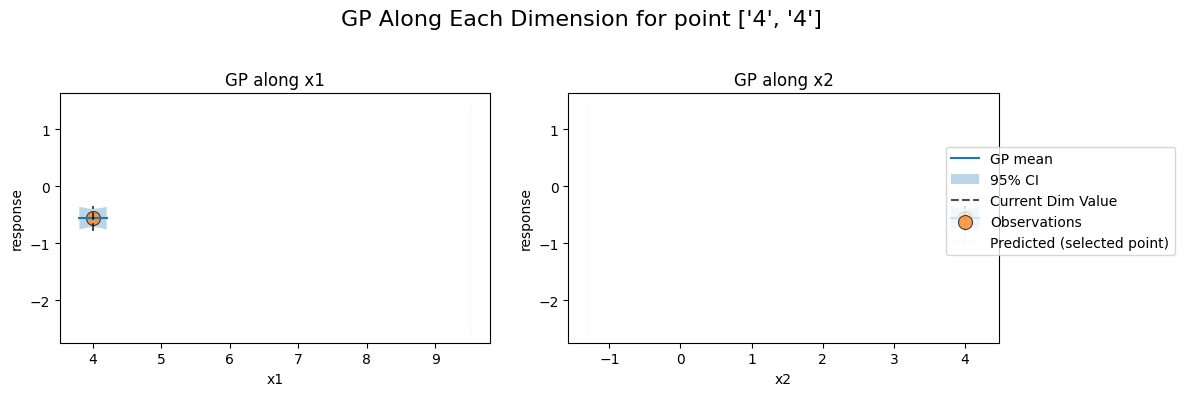

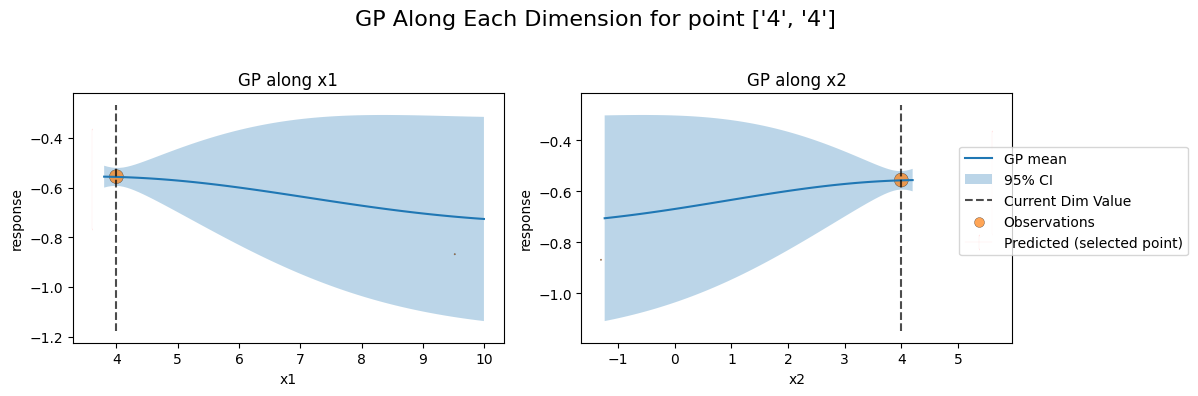

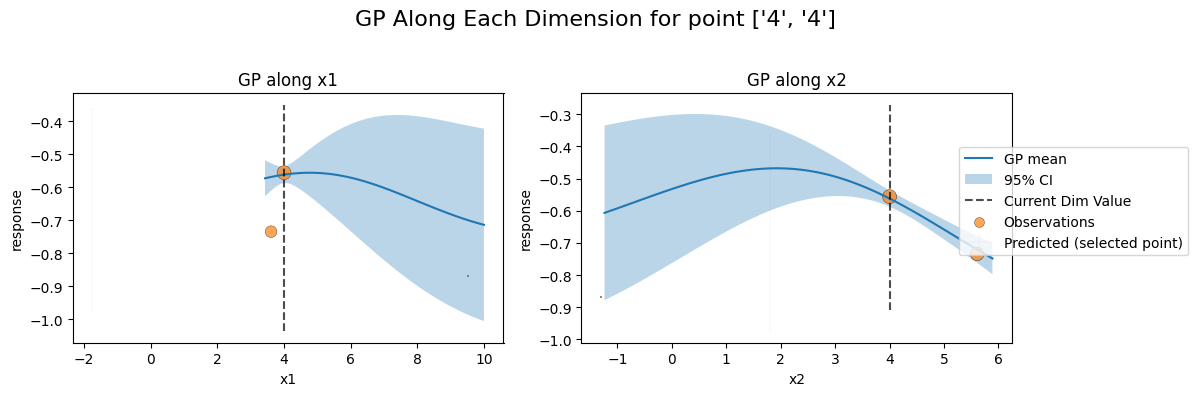

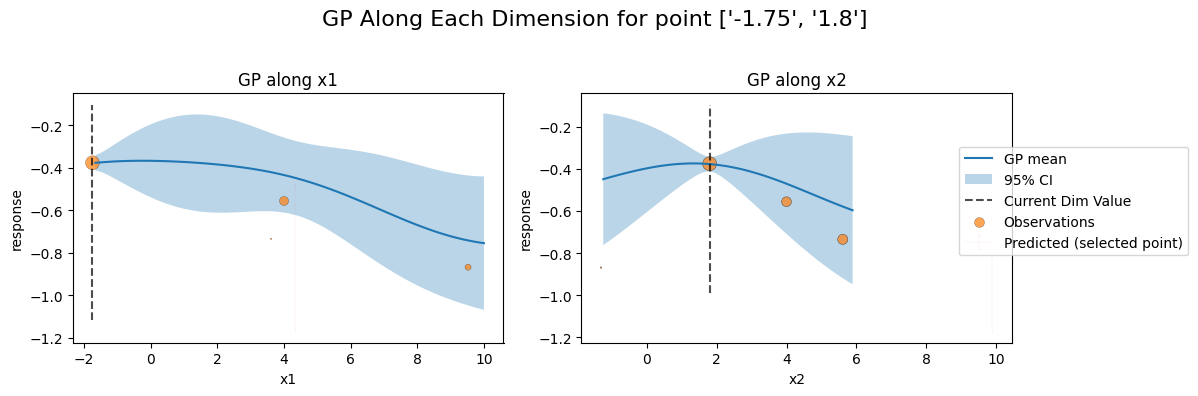

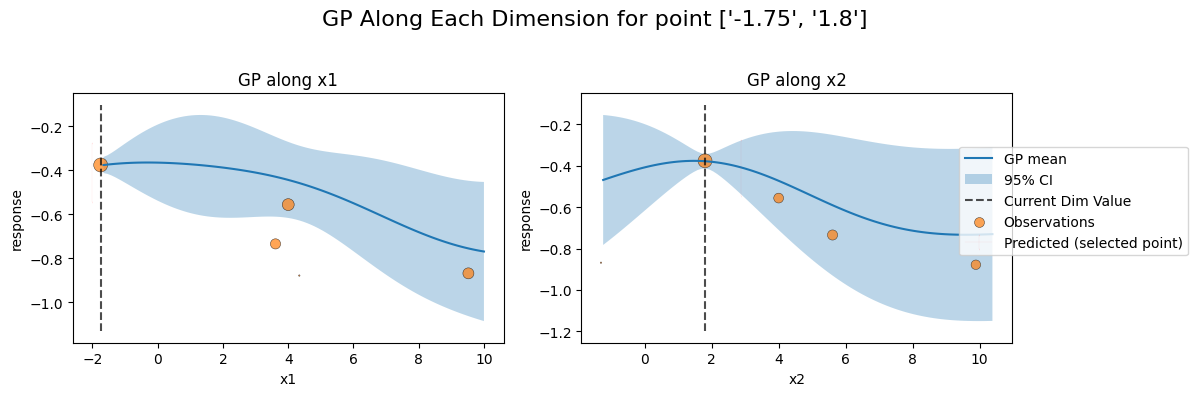

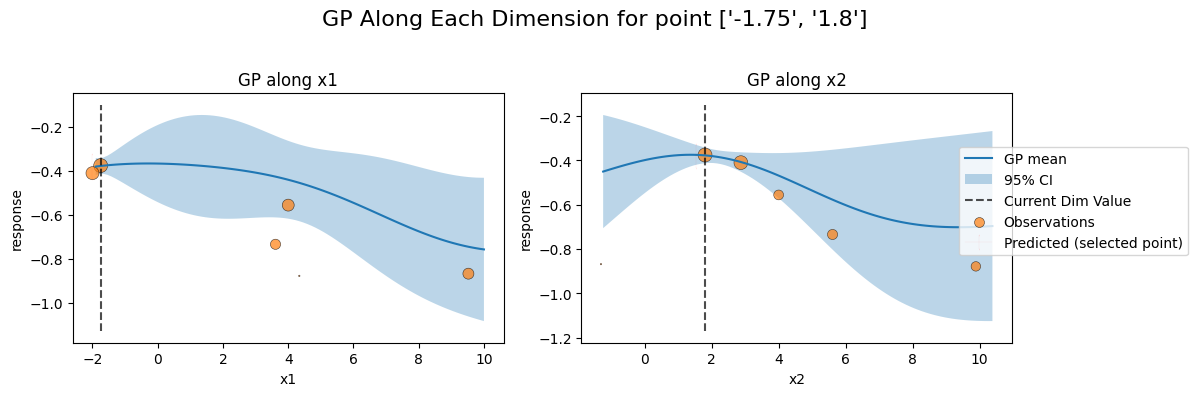

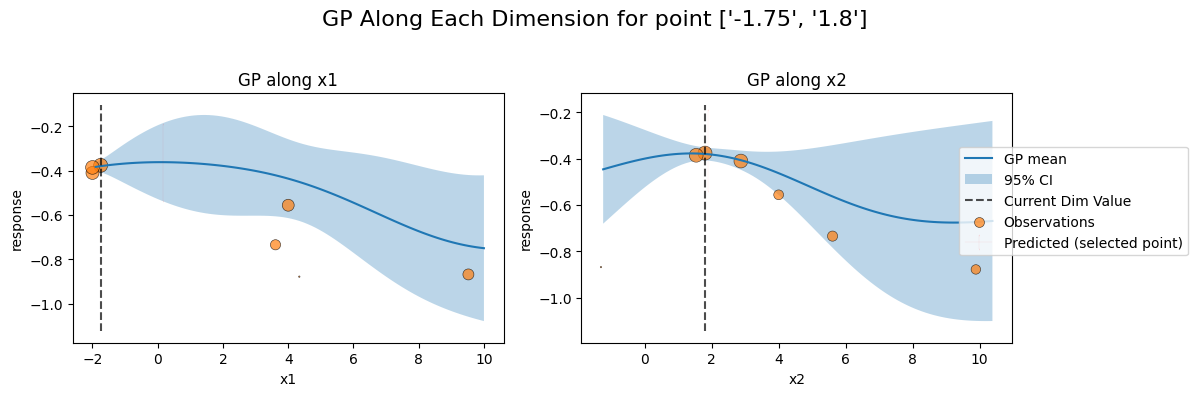

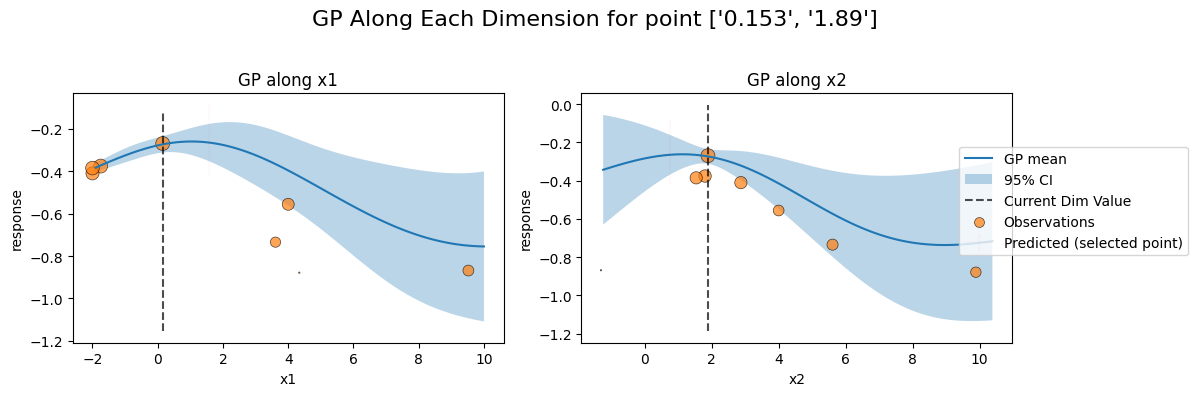

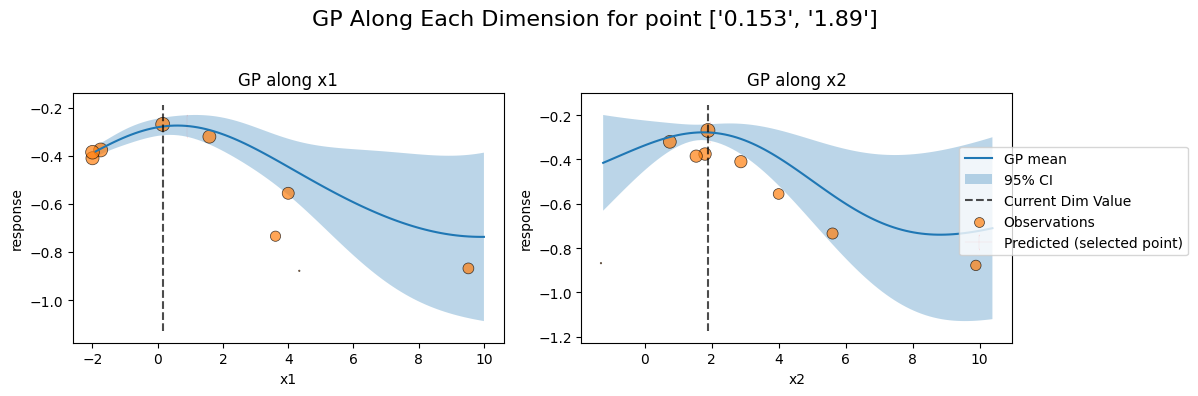

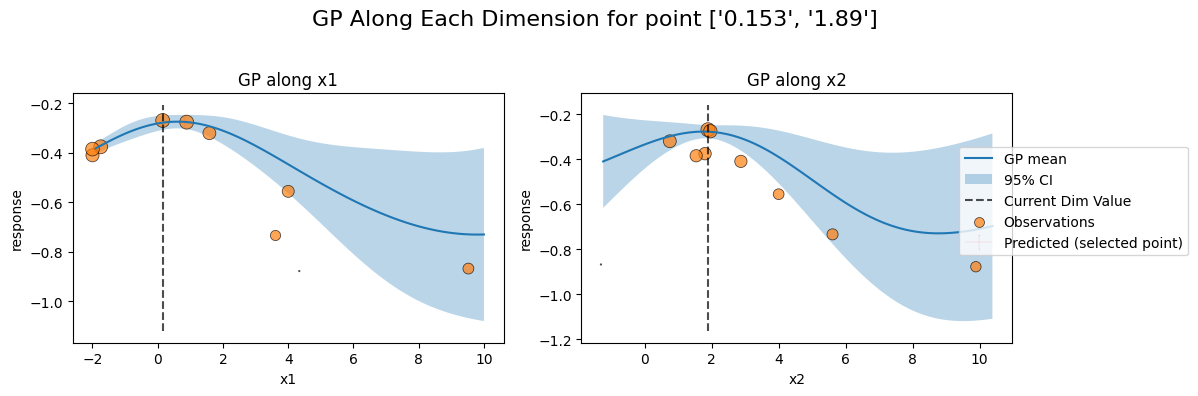

In [9]:
import matplotlib.pyplot as plt
for _ in range(10):
    batch_handler.get_next_batch()

    batch_handler.plot_GP(SingleTaskGP, figsize=(12, 4))
    batch_handler.complete_all_pending()


In [10]:
df

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,5.938944,0.786689,-0.625801
2,2_0,1.006311,5.050948,-0.525179
3,3_0,-1.815365,2.439744,-0.449106
4,4_0,8.994953,9.422567,-0.942075
5,5_0,7.141729,2.849532,-0.717565


# Technical repeats
Knowing that real biological data posses significant significant noise, the model has to be robust enough to handle technical repeats

In [11]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1"]

def test_function(x1):
    # Original: y = -((x1 - 2) ** 2) + 10  -> range on [-2,10] is [-54, 10]
    y = -((x1 - 2) ** 2) + 10
    return (y + 54) / 64  # scale to [0,1]


noise_fn = lambda x: x + np.random.normal(0, 1)

def plot_test():
    plt.plot(np.linspace(-2, 10, 100), [test_function(x) for x in np.linspace(-2, 10, 100)], color='black', label='True function')

In [12]:
from src.ax_helper import SequentialRuns
SequentialRuns

src.ax_helper.SequentialRuns

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



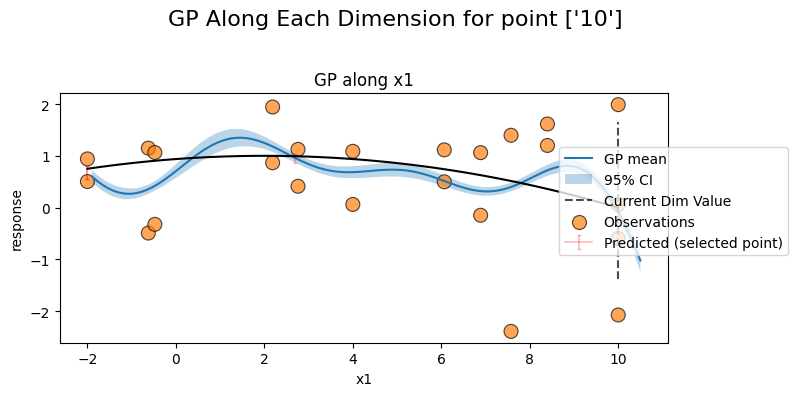

In [13]:
tester = SequentialRuns(test_function, range_parameters, dim_names, metric_name)

runs = tester.run(
    SingleTaskGP,
    n_runs=4,
    technical_repeats=2,
    batch_size=3,
    noise_fn=noise_fn,
    plot_each=False,
)
runs.plot_GP(SingleTaskGP, figsize=(8, 4))
plot_test()

* This simple Kernel is incapable of encompassing noise. Consequently, it overfits.
* Technical repeats slightly improve the situation, however they do not fix the problem.

### GP + noise

Simply adding a lot of noise, significantly improves the fit.
 

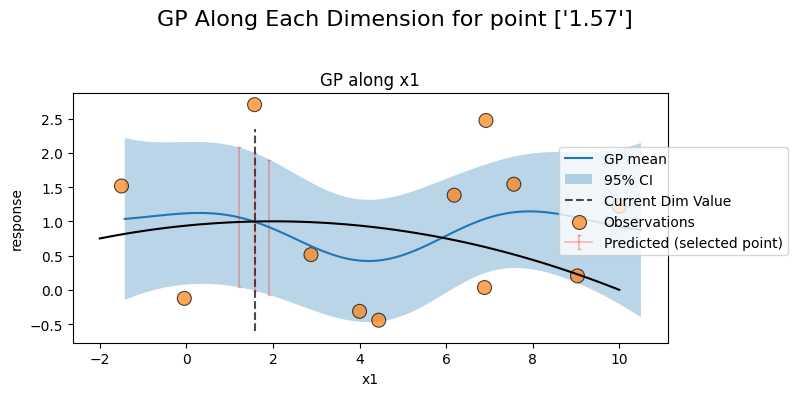

In [14]:
class GammaNoiseSGP(SingleTaskGP):
    """Just add a lot of assumed noise"""

    def __init__(
        self,
        train_X,
        train_Y,
        noise_concentration: float = 10,
        noise_rate: float = 10,
    ):

        likelihood = GaussianLikelihood(
            noise_prior=GammaPrior(noise_concentration, noise_rate)
        )

        super().__init__(
            train_X=train_X,
            train_Y=train_Y,
            likelihood=likelihood,
        )


runs = tester.run(
    GammaNoiseSGP,
    n_runs=4,
    technical_repeats=1,
    batch_size=3,
    noise_fn=noise_fn,
    plot_each=False,
).plot_GP(GammaNoiseSGP, figsize=(8, 4))


plot_test()

* Introducing a noise channel significantly improves fit performance, even if no technical repeats are provided to narrow down the mean.
However,a heteroscedastic, or at least technical repeat aware noise kernel would be preferable.

In [15]:
runs = tester.run(GammaNoiseSGP, n_runs=4, technical_repeats=2, batch_size=3, noise_fn=noise_fn, plot_each=False).plot_GP(GammaNoiseSGP, figsize=(8, 4))
plot_test()

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



KeyboardInterrupt: 

It appears that technical repeats significantly improve noise resolution for the kernel, however, more quantitative tests are required.

# Quantification of Noise, technical repeats, and batch size.

6 dimensional hartman function is used for evaluation, due to its high dimensionality, multiple local optima, ridges and non-linear interactions.

In [ ]:

from src.toy_functions import Hartmann6D
save_dir = "data/bayes_sim/"
h6 = Hartmann6D().eval_at

_h6_x_opt = torch.tensor([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])
h_6_max = [float(h6(*_h6_x_opt)) for _ in range(10000)]
h_6_max

[3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,


In [ ]:
hartmann6_range_parameters = [
    RangeParameterConfig(name=f"x{i+1}", parameter_type="float", bounds=(0.0, 1.0))
    for i in range(6)
]
dim_names_h6 = [rp.name for rp in hartmann6_range_parameters]

tester = SequentialRuns(h6, hartmann6_range_parameters, dim_names_h6, metric_name)
tester

AttributeError: 'function' object has no attribute 'eval_at'

## Sequential runs no noise

In [ ]:
def noise_fn(x):
    return x

save_dir = "data/bayes_sim/"
runs = tester.run(SingleTaskGP, n_runs=100, technical_repeats=1, batch_size=1, noise_fn=noise_fn, plot_each=False)
runs.plot_GP(SingleTaskGP)

In [ ]:

   
df = ax_helper.get_y_data(runs, dim_names_h6, Hartmann6D().eval_at)
df = ax_helper.get_above_percentile(df, h_6_max, 0.9)
df.head(5)

,trial_index,x1,x2,x3,x4,x5,x6,response,y_true,error
22,22,0.376036,0.891908,0.764680,0.579738,0.0,0.0,3.084682,3.084682,0.0
26,26,0.387833,0.872421,0.540706,0.598574,0.0,0.0,3.080150,3.080150,0.0
27,27,0.393571,0.886371,0.693534,0.589728,0.0,0.0,3.113659,3.113659,0.0
49,49,0.398215,0.867687,0.831295,0.579081,0.0,0.0,3.123865,3.123865,0.0
50,50,0.399338,0.863487,0.888193,0.576588,0.0,0.0,3.121644,3.121644,0.0


In [ ]:
param_grid = [(tr, float(n)) for tr in range(1, 9) for n in np.linspace(0, 2.2, 11)]

r_n_dict = {el: _single_run(el) for el in param_grid}

with open(save_dir+'r1-9_noise1-2_dict.pkl', 'wb') as f:
    pickle.dump(r_n_dict, f)

r_n_dict

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\botorch\optim\optimize.py:753: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\botorch\optim\optimize.py:753: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\botor

KeyboardInterrupt: 

In [ ]:
with open(save_dir+'r1-9_noise1-2_dict.pkl', 'wb') as f:
    pickle.dump(r_n_dict, f)

NameError: name 'r_n_dict' is not defined

In [ ]:
result = pd.DataFrame(
    [{'technical_repeats': tr, 'noise': noise, 'best_response': best}
     for (tr, noise), best in r_n_dict.items()]
).sort_values(['technical_repeats', 'noise']).reset_index(drop=True)
result

,technical_repeats,noise,best_response
0,1,0.00,trial_index x1 x2 x3 ...
1,1,0.22,trial_index x1 x2 x3 ...
2,1,0.44,trial_index x1 x2 x3 ...
3,1,0.66,trial_index x1 x2 x3 ...
4,1,0.88,trial_index x1 x2 x3 ...
...,...,...,...
83,8,1.32,trial_index x1 x2 x3 ...
84,8,1.54,trial_index x1 x2 x3 ...
85,8,1.76,trial_index x1 x2 x3 ...
86,8,1.98,trial_index x1 x2 x3 ...


In [ ]:
r_n_dict

processed_dict = {}
for (tr, noise), df in r_n_dict.items():
    print(df['y_true'].max())
    #df = get_above_percentile(df, h_6_max, 0.6)
    processed_dict[(tr, noise)] = df

processed_dict

1.5641748905181885
0.6761985421180725
2.2090413570404053
0.5339521765708923
0.7103486657142639
0.5164057016372681
1.213407039642334
0.5164057016372681
0.9773629307746887
0.9674651622772217
0.5164057016372681
1.8230715990066528
0.6538750529289246
1.8907718658447266
0.8545454144477844
0.8895413875579834
0.7664543986320496
1.229248046875
1.2910079956054688
1.1318379640579224
0.5164057016372681
1.1633845567703247
1.7869874238967896
1.9412988424301147
2.7558517456054688
0.5164057016372681
0.5164057016372681
0.5164057016372681
0.5164057016372681
0.8054777383804321
0.6244006156921387
0.5164057016372681
0.5164057016372681
0.8145254254341125
1.3914941549301147
0.5164057016372681
2.0038020610809326
2.007021427154541
0.5164057016372681
1.7032681703567505
0.5164057016372681
0.5164057016372681
2.131023645401001
0.5164057016372681
0.843153178691864
2.203528881072998
2.7913057804107666
0.7025457620620728
0.5164057016372681
2.2760486602783203
0.5164057016372681
0.5164057016372681
0.5164057016372681
0.

{(1,
  0.0):     trial_index        x1        x2        x3        x4        x5        x6  \
 0             0  0.500000  0.500000  0.500000  0.500000  0.500000  0.500000   
 1             1  0.153827  0.516501  0.663504  0.357013  0.693217  0.751702   
 2             2  0.516317  0.428315  0.365999  0.634753  0.020056  0.258272   
 3             3  0.912935  0.790028  0.930936  0.170392  0.338702  0.050180   
 4             4  0.292883  0.139164  0.102428  0.822339  0.886260  0.557266   
 5             5  0.727251  0.520658  0.351082  0.595074  0.725752  0.685185   
 6             6  0.355252  0.485195  0.566051  0.456685  0.403454  0.452844   
 7             7  0.345620  0.503488  0.650362  0.404656  0.225883  0.277063   
 8             8  0.280820  0.493325  0.537265  0.471612  0.379615  0.601533   
 9             9  0.182827  0.496515  0.527896  0.475917  0.309512  0.703733   
 10           10  0.182011  0.229809  0.739651  0.742685  0.324963  0.713060   
 
     response    y_true  e